# 💻 Notebook de Comparação de Pipelines de Machine Learning (Diabetes)

Este notebook tem como objetivo executar dois pipelines (Esteiras A e B) de Machine Learning no mesmo dataset (diabetes.csv), coletar suas métricas de desempenho e compará-las para determinar a abordagem mais eficaz para o problema de classificação.

## 1. Configuração e Funções Comuns
### 1.1 Instalação e Importação de Bibliotecas
Instale todas as dependências necessárias para ambos os pipelines.

In [118]:
# Célula 1.1: Instalação (descomente se necessário)
# !pip install pandas numpy scikit-learn matplotlib seaborn imblearn xgboost kagglehub shap

# Célula 1.1: Importações
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import kagglehub
import shap
import xgboost as xgb

# Scikit-learn e Imblearn
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import recall_score, f1_score, precision_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import SMOTE

# Configuração para evitar warnings do SHAP
shap.initjs()

print("Todas as bibliotecas e ferramentas foram importadas.")

Todas as bibliotecas e ferramentas foram importadas.


### 1.2 Funções Auxiliares Comuns
As funções de tradução e carregamento serão centralizadas aqui. O carregamento usará o método do Pipeline A (KaggleHub) para simplificar a obtenção dos dados.

In [119]:
# Célula 1.2: Funções Auxiliares Comuns

DATASET_HANDLE = 'mathchi/diabetes-data-set'
TARGET_COL = 'Outcome'
DATA_PATH_TEMP = 'temp_data_file.csv' # Nome temporário do arquivo CSV após download

def traduzir_colunas(dados: pd.DataFrame) -> pd.DataFrame:
    '''Traduz os nomes das colunas.'''
    return dados.rename(columns={
        'Pregnancies': 'Gestações',
        'Glucose': 'Glicose',
        'BloodPressure': 'Pressão',
        'SkinThickness': 'Espessura da pele',
        'Insulin': 'Insulina',
        'BMI': 'IMC',
        'DiabetesPedigreeFunction': 'Hereditariedade',
        'Age': 'Idade',
        'Outcome': 'Diagnóstico'
    })

def carregar_e_salvar_kaggle(handle: str, save_path: str) -> pd.DataFrame:
    '''Carrega o dataset do KaggleHub, salva o CSV localmente e retorna o DataFrame.'''
    print(f'Iniciando o carregamento dos dados de: {handle}')
    
    # Baixar e obter o caminho do arquivo
    endereco_de_origem = kagglehub.dataset_download(handle=handle, force_download=True)
    diretorio_de_origem = Path(endereco_de_origem).resolve()
    
    # Encontrar e carregar o CSV
    lista_dados_csv = []
    for item in diretorio_de_origem.iterdir():
        if item.is_file() and item.suffix.lower() == '.csv':
            df = pd.read_csv(item)
            lista_dados_csv.append(df)
            # Salvar em um local conhecido para o Pipeline B usar (se necessário)
            df.to_csv(save_path, index=False)
            print(f"Arquivo CSV salvo temporariamente em '{save_path}'")
            
    if not lista_dados_csv:
        raise FileNotFoundError("Nenhum arquivo CSV encontrado no dataset do Kaggle.")
        
    dados = pd.concat(lista_dados_csv, axis=0, ignore_index=True)
    print('Finalizando o carregamento dos dados\n')
    return dados

# Carregar o dataset para que ambos os pipelines possam utilizá-lo
dados_originais = carregar_e_salvar_kaggle(DATASET_HANDLE, DATA_PATH_TEMP)
print(f"Shape dos dados carregados: {dados_originais.shape}")

Iniciando o carregamento dos dados de: mathchi/diabetes-data-set


100%|██████████| 8.91k/8.91k [00:00<?, ?B/s]

Extracting files...
Arquivo CSV salvo temporariamente em 'temp_data_file.csv'
Finalizando o carregamento dos dados

Shape dos dados carregados: (768, 9)


## 2. Execução do Pipeline A (Modelo MLOps - Baseline)
Este pipeline se concentra em uma abordagem robusta de pré-processamento (KNN Imputer, RobustScaler) e avaliação de um conjunto diversificado de modelos (RegLog, DT, RF, KNN) com foco no Recall.

### 2.1 Funções Exclusivas do Pipeline A

In [120]:
# Célula 2.1: Funções Exclusivas do Pipeline A

def separar_A(dados: pd.DataFrame, target: str):
    '''Separa features e alvo, e divide em treino e teste (80/20 estratificado).'''
    X_dados = dados.drop(columns=[target], axis=1)
    y_dados = dados[target]
    return train_test_split(X_dados, y_dados, test_size=0.2, random_state=42, stratify=y_dados)

def imputar_A(X_treino: pd.DataFrame, X_teste: pd.DataFrame):
    '''Substitui zeros inválidos por NaN e usa KNNImputer (k=5).'''
    print('Iniciando a imputação dos dados (KNN)')
    colunas_invalidas = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'Age']
    X_treino[colunas_invalidas] = X_treino[colunas_invalidas].replace(0, np.nan)
    X_teste[colunas_invalidas] = X_teste[colunas_invalidas].replace(0, np.nan)
    imputer = KNNImputer(n_neighbors=5)
    
    # Usando .copy() para garantir que a transformação não afete o DataFrame original global
    X_treino_imputado = pd.DataFrame(imputer.fit_transform(X_treino), columns=X_treino.columns, index=X_treino.index)
    X_teste_imputado = pd.DataFrame(imputer.transform(X_teste), columns=X_teste.columns, index=X_teste.index)
    
    print('Finalizando a imputação dos dados\n')
    return X_treino_imputado, X_teste_imputado

def balancear_A(X_treino: pd.DataFrame, y_treino: pd.DataFrame):
    '''Equilibra a quantidade de dados por diagnóstico usando SMOTE.'''
    print('Iniciando o balanceamento dos dados (SMOTE)')
    X_treino_balanceado, y_treino_balanceado = SMOTE(random_state=42).fit_resample(X_treino, y_treino)
    print(f'Finalizando o balanceamento dos dados. Novos positivos: {y_treino_balanceado.sum()}\n')
    return X_treino_balanceado, y_treino_balanceado

def padronizar_A(X_treino: pd.DataFrame, X_teste: pd.DataFrame):
    '''Aplica padronização nas colunas usando RobustScaler.'''
    print('Iniciando o escalonamento dos dados (RobustScaler)')
    scaler = RobustScaler()
    X_treino_padronizado = pd.DataFrame(scaler.fit_transform(X_treino), columns=X_treino.columns, index=X_treino.index)
    X_teste_padronizado = pd.DataFrame(scaler.transform(X_teste), columns=X_teste.columns, index=X_teste.index)
    print('Finalizando o escalonamento dos dados\n')
    return X_treino_padronizado, X_teste_padronizado

def criar_modelos_A():
    '''Gera uma lista de instâncias de modelos para avaliação.'''
    return {
        'Logistic Regression (A)': LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42),
        'Decision Tree (A)': DecisionTreeClassifier(class_weight='balanced', criterion='entropy', max_depth=4, min_samples_split=10, min_samples_leaf=5, random_state=42),
        'KNeighbors (A)': KNeighborsClassifier(n_neighbors=5, weights='distance'),
        'Random Forest (A)': RandomForestClassifier(class_weight='balanced', n_estimators=200, random_state=42)
    }

def avaliar_A(modelos, X_teste, y_teste):
    '''Avalia modelos e retorna o de melhor Recall, coletando os resultados.'''
    print('Iniciando a avaliação dos modelos do Pipeline A')
    resultados = []
    
    for nome, modelo in modelos.items():
        y_previsto = modelo.predict(X_teste)
        
        resultados.append({
            'Pipeline': 'A',
            'Modelo': nome,
            'Precision': precision_score(y_teste, y_previsto, zero_division=0),
            'Recall': recall_score(y_teste, y_previsto, zero_division=0),
            'F1-score': f1_score(y_teste, y_previsto, zero_division=0),
        })
        print(f'\n--- Classificação do modelo {nome} ---')
        print(classification_report(y_teste, y_previsto, zero_division=0))

    df_resultados = pd.DataFrame(resultados)
    
    melhor_modelo_df = df_resultados.loc[df_resultados['Recall'].idxmax()]
    nome_melhor_modelo = melhor_modelo_df['Modelo']
    melhor_modelo = modelos[nome_melhor_modelo]
    
    print(f'\nMelhor modelo (baseado em Recall): {nome_melhor_modelo}')
    return melhor_modelo, df_resultados

def treinar_A(modelos, X_treino, y_treino):
    '''Treina uma lista de modelos.'''
    print('Iniciando o treino dos modelos do Pipeline A')
    for modelo in modelos.values():
        modelo.fit(X_treino, y_treino)
    print('Finalizando o treino dos modelos\n')
    return modelos

### 2.2 Execução do Fluxo A

In [121]:
# Célula 2.2: Fluxo Principal do Pipeline A

print('=============================================')
print('=== EXECUTANDO O PIPELINE A (BASELINE) ===')
print('=============================================\n')

dados_A = dados_originais.copy()

# 1. Separar Treino/Teste
X_treino_A, X_teste_A, y_treino_A, y_teste_A = separar_A(dados_A, TARGET_COL)

# 2. Imputação (KNN Imputer)
X_treino_imputado_A, X_teste_imputado_A = imputar_A(X_treino_A.copy(), X_teste_A.copy())

# 3. Balanceamento (SMOTE)
X_treino_base_A, y_treino_base_A = balancear_A(X_treino_imputado_A, y_treino_A)

# 4. Padronização (RobustScaler)
X_treino_padronizado_A, X_teste_padronizado_A = padronizar_A(X_treino_base_A, X_teste_imputado_A)
feat_names_A = X_treino_padronizado_A.columns.tolist()

# 5. Modelagem e Treinamento
modelos_A = criar_modelos_A()
modelos_treinados_A = treinar_A(modelos_A, X_treino_padronizado_A, y_treino_base_A)

# 6. Avaliação e Coleta de Resultados
melhor_modelo_A, resultados_A = avaliar_A(modelos_treinados_A, X_teste_padronizado_A, y_teste_A)

print('\n=============================================')
print(f'RESULTADOS FINAIS DO PIPELINE A COLETADOS.')
print('=============================================\n')

=== EXECUTANDO O PIPELINE A (BASELINE) ===

Iniciando a imputação dos dados (KNN)
Finalizando a imputação dos dados

Iniciando o balanceamento dos dados (SMOTE)
Finalizando o balanceamento dos dados. Novos positivos: 400

Iniciando o escalonamento dos dados (RobustScaler)
Finalizando o escalonamento dos dados

Iniciando o treino dos modelos do Pipeline A
Finalizando o treino dos modelos

Iniciando a avaliação dos modelos do Pipeline A

--- Classificação do modelo Logistic Regression (A) ---
              precision    recall  f1-score   support

           0       0.83      0.75      0.79       100
           1       0.61      0.72      0.66        54

    accuracy                           0.74       154
   macro avg       0.72      0.74      0.73       154
weighted avg       0.75      0.74      0.74       154


--- Classificação do modelo Decision Tree (A) ---
              precision    recall  f1-score   support

           0       0.85      0.73      0.78       100
           1     

## 3. Execução do Pipeline B (Otimizado/Deep Dive)

Este pipeline possui pré-processamento diferente (remoção de colunas, Feature Engineering, SimpleImputer com mediana) e inclui o modelo XGBoost, avaliando as previsões com um threshold de $0.3$.

### 3.1 Funções Exclusivas do Pipeline B

In [122]:
# Célula 3.1: Funções Exclusivas do Pipeline B

def split_and_oversample(X, y, test_size=0.2, random_state=42, stratify=True, smote_random_state=42):
    """
    Faz split dos dados em treino/teste e aplica SMOTE apenas nos dados de treino.

    Parâmetros:
        X (array ou DataFrame): Features já processadas/escaladas.
        y (array ou Series): Labels/variável alvo.
        test_size (float): Proporção de teste.
        random_state (int): Semente para reprodutibilidade.
        stratify (bool): Se True, faz stratify em y.
        smote_random_state (int): Semente do SMOTE.

    Retorna:
        X_train_res, X_test, y_train_res, y_test
    """
    strat = y if stratify else None
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=strat
    )

    smote = SMOTE(random_state=smote_random_state)
    X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

    return X_train_res, X_test, y_train_res, y_test

def preprocess_diabetes_data_B(df: pd.DataFrame):
    """
    Pré-processamento:
    - Remove SkinThickness e Insulin
    - Trata zeros em Glucose, BloodPressure, BMI (converte para NaN e imputa mediana)
    - Feature engineering: cria variáveis de risco
    """
    df = df.copy() 
    
    # 1. Remove colunas
    df = df.drop(['SkinThickness', 'Insulin'], axis=1)
    
    # 2. Trata zeros biologicamente impossíveis (SimpleImputer Mediana)
    cols_to_treat = ['Glucose', 'BloodPressure', 'BMI']
    for col in cols_to_treat:
        df[col] = df[col].replace(0, np.nan)
        
    imputer = SimpleImputer(strategy='median')
    df[cols_to_treat] = imputer.fit_transform(df[cols_to_treat])

    # 3. FEATURE ENGINEERING: Variáveis de risco
    df['idade_maior_45'] = (df['Age'] >= 45).astype(int)
    df['imc_obeso'] = (df['BMI'] >= 30).astype(int)
    df['idade_bmi'] = df['Age'] * df['BMI']
    df['glucose_bmi'] = df['Glucose'] * df['BMI']

    # 4. Separa features e target
    X = df.drop('Outcome', axis=1)
    y = df['Outcome'].values
    feat_names = X.columns.tolist()

    # 5. Scaling (RobustScaler - Ajustado para o fluxo do notebook)
    scaler = RobustScaler()
    X_scaled = scaler.fit_transform(X)
    X_scaled_df = pd.DataFrame(X_scaled, columns=feat_names, index=X.index)
    
    return X_scaled_df, y, feat_names

def get_models():
    """
    Cria e retorna dicionário com modelos de classificação configurados para melhor recall.
    """    
    return {
        'Logistic Regression': LogisticRegression(class_weight='balanced', random_state=42),
        'Decision Tree': DecisionTreeClassifier(class_weight='balanced', random_state=42),
        'Random Forest': RandomForestClassifier(class_weight='balanced', n_estimators=100, random_state=42),
        'XGBoost': xgb.XGBClassifier(scale_pos_weight=1, use_label_encoder=False, eval_metric='logloss', random_state=42)
    }

def train_models(models, X_train, y_train):
    for model in models.values():
        model.fit(X_train, y_train)
    return models

def evaluate_models(models, X_test, y_test, feat_names, threshold=0.3):
    """
    Avalia múltiplos modelos de classificação, exibe métricas e matriz de confusão,
    e retorna o modelo com o melhor Recall.
    """
    best_recall = -1
    best_f1 = -1
    best_model_name = None
    best_model = None
    results = []

    for name, model in models.items():

        if hasattr(model, "predict_proba"):
            y_proba = model.predict_proba(X_test)[:, 1]
            y_pred = (y_proba >= threshold).astype(int)
        else:
            y_pred = model.predict(X_test)
            
        current_recall = recall_score(y_test, y_pred)
        current_f1 = f1_score(y_test, y_pred)
        current_precision = precision_score(y_test, y_pred, zero_division=0)

        results.append({
            'Pipeline': 'B',
            'Modelo': name,
            'Precision': current_precision,
            'Recall': current_recall,
            'F1-score': current_f1,
        })
        
        # Lógica de rastreamento do melhor modelo (Baseado no Recall)
        if current_recall > best_recall:
            best_recall = current_recall
            best_f1 = current_f1 
            best_model_name = name
            best_model = model

        print(f"\n--- {name} ---")
        print(f"Recall (Sensibilidade): {current_recall:.2f}")
        print(f"F1-score: {current_f1:.2f}")
        print("\nRelatório de classificação detalhado:")
        print(classification_report(y_test, y_pred))
        print("Matriz de Confusão (linhas = real, colunas = predito):")
        sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
        plt.title(f'Matriz de Confusão - {name} (Threshold={threshold})')
        plt.xlabel('Predito')
        plt.ylabel('Real')
        plt.show()

    print("==================================================")
    print(f"🏆 Melhor Modelo Encontrado ({best_model_name})")
    print(f"   Critério de Seleção: Maior Recall")
    print(f"   Recall (Sensibilidade): {best_recall:.2f}")
    print(f"   F1-score: {best_f1:.2f}")
    print("==================================================")

    df_results = pd.DataFrame(results)
    
    return best_model, df_results, best_model_name

### 3.2 Execução do Fluxo B

=== EXECUTANDO O PIPELINE B (OTIMIZADO/DEEP DIVE) ===



[18:40:14] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

X does not have valid feature names, but LogisticRegression was fitted with feature names



--- Logistic Regression ---
Recall (Sensibilidade): 0.85
F1-score: 0.63

Relatório de classificação detalhado:
              precision    recall  f1-score   support

           0       0.87      0.55      0.67       100
           1       0.51      0.85      0.63        54

    accuracy                           0.66       154
   macro avg       0.69      0.70      0.65       154
weighted avg       0.74      0.66      0.66       154

Matriz de Confusão (linhas = real, colunas = predito):


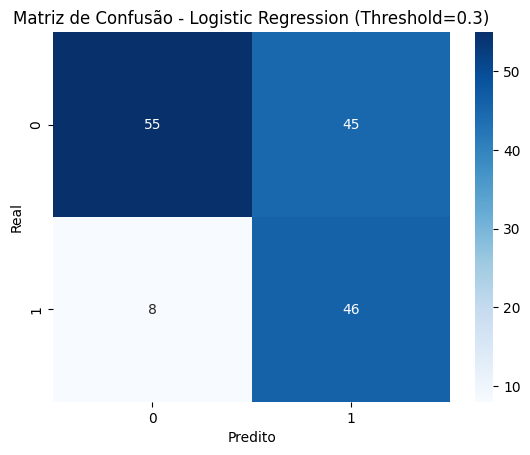


--- Decision Tree ---
Recall (Sensibilidade): 0.56
F1-score: 0.56

Relatório de classificação detalhado:
              precision    recall  f1-score   support

           0       0.76      0.76      0.76       100
           1       0.56      0.56      0.56        54

    accuracy                           0.69       154
   macro avg       0.66      0.66      0.66       154
weighted avg       0.69      0.69      0.69       154

Matriz de Confusão (linhas = real, colunas = predito):


X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names


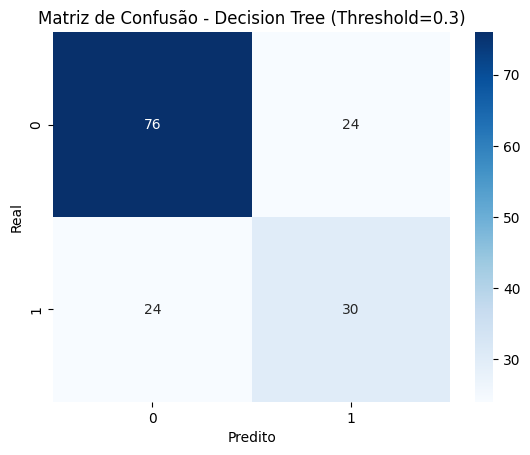

X does not have valid feature names, but RandomForestClassifier was fitted with feature names



--- Random Forest ---
Recall (Sensibilidade): 0.91
F1-score: 0.72

Relatório de classificação detalhado:
              precision    recall  f1-score   support

           0       0.93      0.66      0.77       100
           1       0.59      0.91      0.72        54

    accuracy                           0.75       154
   macro avg       0.76      0.78      0.74       154
weighted avg       0.81      0.75      0.75       154

Matriz de Confusão (linhas = real, colunas = predito):


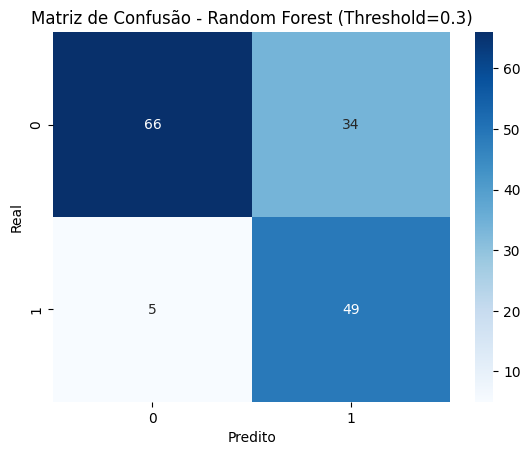


--- XGBoost ---
Recall (Sensibilidade): 0.76
F1-score: 0.67

Relatório de classificação detalhado:
              precision    recall  f1-score   support

           0       0.85      0.73      0.78       100
           1       0.60      0.76      0.67        54

    accuracy                           0.74       154
   macro avg       0.73      0.74      0.73       154
weighted avg       0.76      0.74      0.75       154

Matriz de Confusão (linhas = real, colunas = predito):


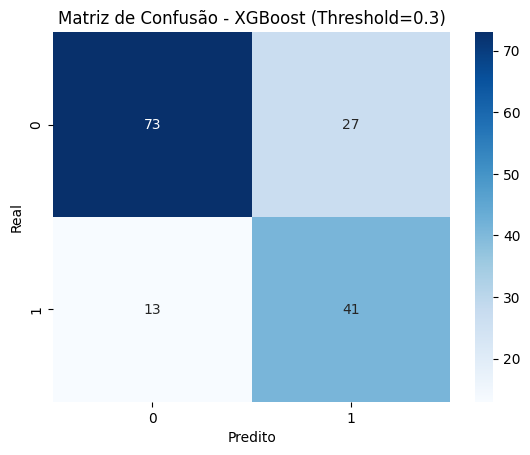

🏆 Melhor Modelo Encontrado (Random Forest)
   Critério de Seleção: Maior Recall
   Recall (Sensibilidade): 0.91
   F1-score: 0.72

RESULTADOS FINAIS DO PIPELINE B COLETADOS.



In [123]:
# Célula 3.2: Fluxo Principal do Pipeline B

print('==================================================')
print('=== EXECUTANDO O PIPELINE B (OTIMIZADO/DEEP DIVE) ===')
print('==================================================\n')

# 1. Pré-processamento e Feature Engineering
# Carregar os dados do arquivo temporário salvo anteriormente
dados_B = pd.read_csv(DATA_PATH_TEMP) 

X_scaled_B, y_B, feat_names_B = preprocess_diabetes_data_B(dados_B)

# 2. Split e Balanceamento (SMOTE)
X_train_res_B, X_test_B, y_train_res_B, y_test_B = split_and_oversample(
    X_scaled_B.values, y_B, test_size=0.2, random_state=42, stratify=True
)
# Reconverter X_train_res_B para DataFrame para compatibilidade com nomes de features
X_train_res_B_df = pd.DataFrame(X_train_res_B, columns=feat_names_B)

# 3. Modelagem e Treinamento
models_B = get_models()
models_treinados_B = train_models(models_B, X_train_res_B_df, y_train_res_B)

# 4. Avaliação e Coleta de Resultados (com threshold 0.3)
melhor_modelo_B, resultados_B, best_model_name = evaluate_models(models_treinados_B, X_test_B, y_test_B, feat_names_B, threshold=0.3)

print('\n=============================================')
print(f'RESULTADOS FINAIS DO PIPELINE B COLETADOS.')
print('=============================================\n')

## 4. Comparação e Interpretação dos Resultados
Nesta seção, consolidaremos os resultados de ambos os pipelines e visualizaremos as principais diferenças em termos de desempenho (métricas) e fatores de influência (importância das features).

### 4.1 Comparação das Métricas de Desempenho

--- Tabela Consolidada de Métricas (A vs B) ---
  Pipeline                   Modelo  Precision    Recall  F1-score
0        A  Logistic Regression (A)   0.609375  0.722222  0.661017
1        A        Decision Tree (A)   0.602941  0.759259  0.672131
2        A           KNeighbors (A)   0.560000  0.777778  0.651163
3        A        Random Forest (A)   0.603175  0.703704  0.649573
4        B      Logistic Regression   0.505495  0.851852  0.634483
5        B            Decision Tree   0.555556  0.555556  0.555556
6        B            Random Forest   0.590361  0.907407  0.715328
7        B                  XGBoost   0.602941  0.759259  0.672131


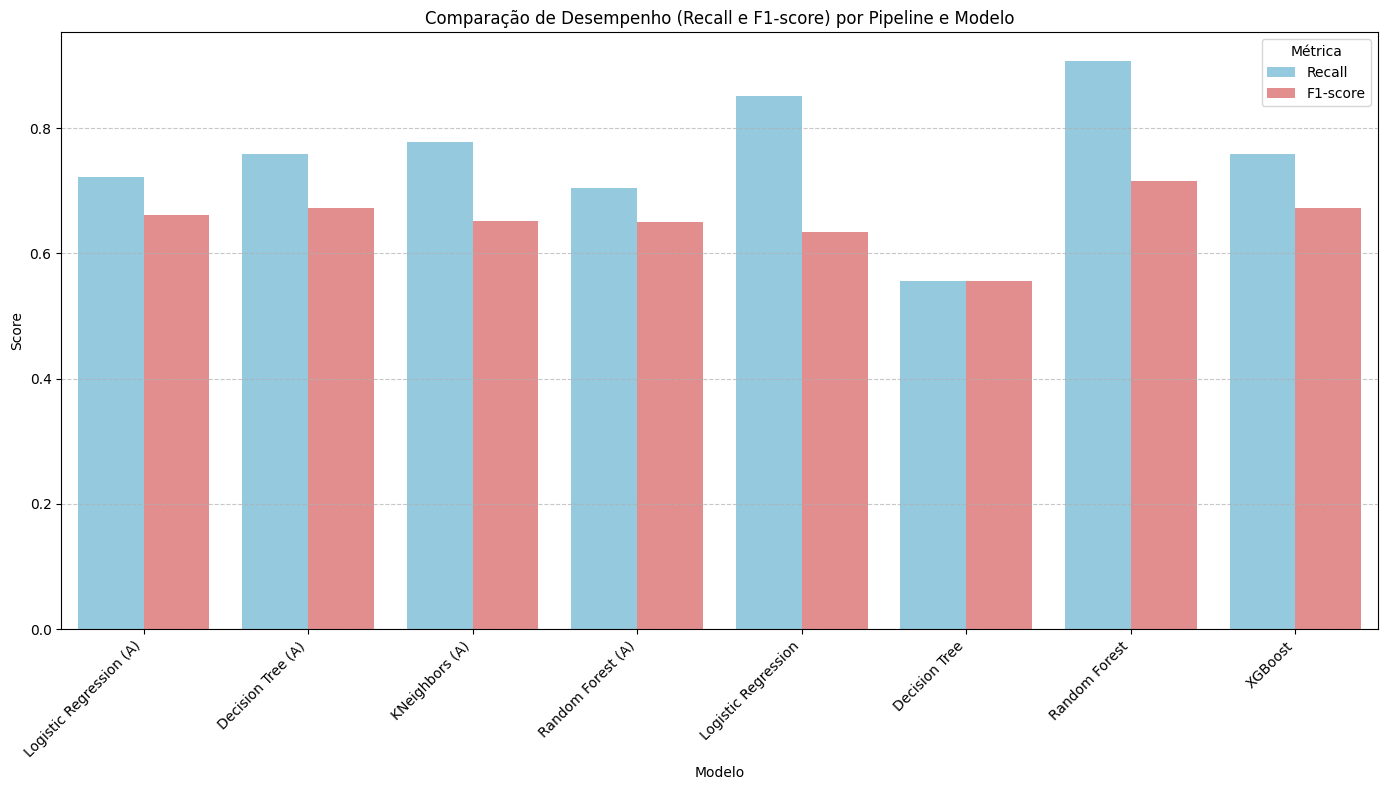


--- Comparação dos Melhores Modelos (Recall Máximo) ---
  Pipeline          Modelo  Precision    Recall  F1-score
0        A  KNeighbors (A)   0.560000  0.777778  0.651163
1        B   Random Forest   0.590361  0.907407  0.715328


In [124]:
# Célula 4.1: Comparação Consolidada de Métricas

# 1. Consolidação
resultados_consolidados = pd.concat([resultados_A, resultados_B], ignore_index=True)
print("--- Tabela Consolidada de Métricas (A vs B) ---")
print(resultados_consolidados)

# 2. Gráfico de Barras Comparativo (Recall e F1-score)
df_plot = resultados_consolidados.melt(id_vars=['Pipeline', 'Modelo'],
                                       value_vars=['Recall', 'F1-score'],
                                       var_name='Métrica',
                                       value_name='Score')

plt.figure(figsize=(14, 8))
sns.barplot(x='Modelo', y='Score', hue='Métrica', data=df_plot,
            palette={'Recall': 'skyblue', 'F1-score': 'lightcoral'})
plt.title('Comparação de Desempenho (Recall e F1-score) por Pipeline e Modelo')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Métrica')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# 3. Comparação Direta dos Melhores Modelos
# Get the name of the best model from Pipeline A based on max recall
melhor_modelo_A_name = resultados_A.loc[resultados_A['Recall'].idxmax()]['Modelo']
melhor_A = resultados_A.loc[resultados_A['Modelo'] == melhor_modelo_A_name]

# Get the name of the best model from Pipeline B based on max recall
melhor_modelo_B_name = resultados_B.loc[resultados_B['Recall'].idxmax()]['Modelo']
melhor_B = resultados_B.loc[resultados_B['Modelo'] == melhor_modelo_B_name]


df_melhores = pd.concat([melhor_A, melhor_B], ignore_index=True)

print("\n--- Comparação dos Melhores Modelos (Recall Máximo) ---")
print(df_melhores[['Pipeline', 'Modelo', 'Precision', 'Recall', 'F1-score']])

### 4.2 Interpretação Comparativa da Importância das Features
A comparação aqui é crucial, pois o Pipeline B adicionou novas features e removeu outras.

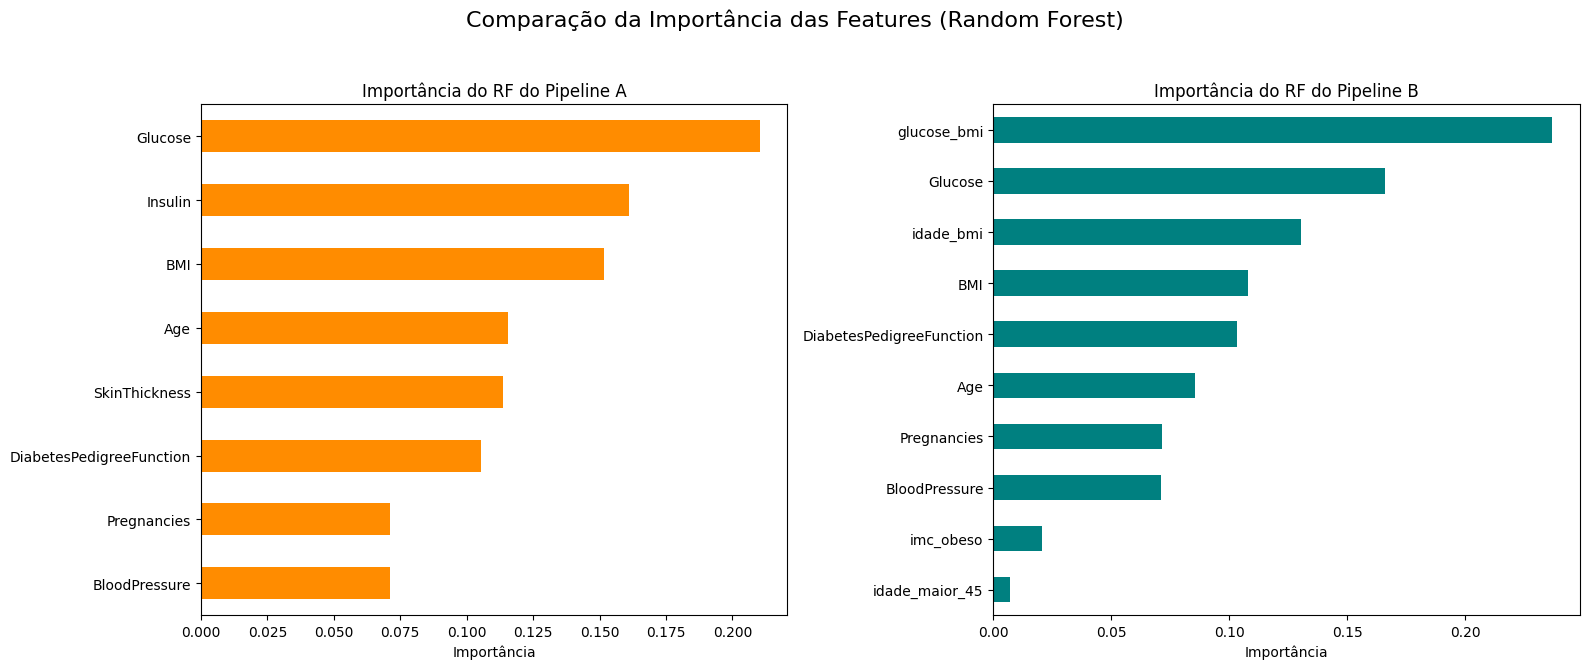


--- Conclusão da Análise de Features ---
Observe as diferenças: O Pipeline B removeu 'SkinThickness' e 'Insulin' e adicionou 'idade_maior_45', 'imc_obeso', 'idade_bmi' e 'glucose_bmi'.
A importância das features no Pipeline B deve mostrar o impacto destas novas variáveis e a ausência das removidas.


In [ ]:
# Célula 4.2: Interpretação e Comparação de Features

def plot_feature_importances(modelo, X_data, title, ax):
    """Função auxiliar para plotar a importância das features."""
    if hasattr(modelo, 'feature_importances_'):
        importances = modelo.feature_importances_
        features = X_data.columns if isinstance(X_data, pd.DataFrame) else [f'Feature {i}' for i in range(X_data.shape[1])]
        feature_importance = pd.Series(importances, index=features).sort_values(ascending=True)
        feature_importance.plot(kind='barh', ax=ax, title=title, color='teal' if 'B' in title else 'darkorange')
        ax.set_xlabel('Importância')
    else:
        ax.set_title(f"{title}\n(Modelo sem Feature Importance direta)")
        ax.axis('off')

# O modelo mais comum a ser o melhor é o Random Forest nos dois pipelines
# Vamos usar o Random Forest de cada um para uma comparação justa de Importância das Features.

rf_A = modelos_treinados_A['Random Forest (A)']
# Usamos o DataFrame padronizado do treino para obter os nomes corretos
# X_train_RF_A = X_treino_padronizado_A.drop(['Gestações', 'Glicose', 'Pressão', 'Espessura da pele', 'Insulina', 'IMC', 'Hereditariedade', 'Idade'], axis=1)
X_train_RF_A = X_treino_padronizado_A.copy()


rf_B = models_treinados_B['Random Forest'] 
X_train_RF_B = X_train_res_B_df.copy() # DataFrame do treino B já com as features B

fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# 1. Comparação de Importância (Usando Random Forest como exemplo)
plot_feature_importances(rf_A, X_train_RF_A, 'Importância do RF do Pipeline A', axes[0])
plot_feature_importances(rf_B, X_train_RF_B, 'Importância do RF do Pipeline B', axes[1])

plt.suptitle('Comparação da Importância das Features (Random Forest)', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# 2. Interpretação do Melhor Modelo Geral (Se houver uma diferença clara)

print("\n--- Conclusão da Análise de Features ---")
print("Observe as diferenças: O Pipeline B removeu 'SkinThickness' e 'Insulin' e adicionou 'idade_maior_45', 'imc_obeso', 'idade_bmi' e 'glucose_bmi'.")
print("A importância das features no Pipeline B deve mostrar o impacto destas novas variáveis e a ausência das removidas.")

### 4.3 Conclusão

In [126]:
# Célula 4.3: Conclusão Final

print("=====================================================")
print("========= SÍNTESE FINAL DA COMPARAÇÃO ==========")
print("=====================================================")

# Obter o Recall do melhor modelo de cada pipeline
recall_A_max = resultados_A['Recall'].max()
recall_B_max = resultados_B['Recall'].max()
f1_A_max = resultados_A['F1-score'].max()
f1_B_max = resultados_B['F1-score'].max()

print(f"\nMelhor Recall do Pipeline A (Baseline): {recall_A_max:.4f}")
print(f"Melhor Recall do Pipeline B (Otimizado): {recall_B_max:.4f}")
print(f"\nMelhor F1-score do Pipeline A (Baseline): {f1_A_max:.4f}")
print(f"Melhor F1-score do Pipeline B (Otimizado): {f1_B_max:.4f}")

if recall_B_max > recall_A_max:
    diferenca = recall_B_max - recall_A_max
    print(f"\nCONCLUSÃO: O PIPELINE B é superior em Recall, apresentando uma melhoria de {diferenca:.4f} pontos.")
    print("Isso sugere que a remoção de colunas com ruído (SkinThickness/Insulin), a Feature Engineering e o uso do Threshold 0.3/XGBoost foram eficazes para aumentar a sensibilidade do diagnóstico.")
elif recall_A_max > recall_B_max:
    diferenca = recall_A_max - recall_B_max
    print(f"\nCONCLUSÃO: O PIPELINE A é superior em Recall, apresentando uma melhoria de {diferenca:.4f} pontos.")
    print("Isso sugere que a imputação mais complexa (KNN) e a retenção das features originais foram mais benéficas.")
else:
    print("\nCONCLUSÃO: Os pipelines têm desempenho de Recall muito semelhante. A escolha pode depender da complexidade de manutenção e tempo de execução.")

========= SÍNTESE FINAL DA COMPARAÇÃO ==========

Melhor Recall do Pipeline A (Baseline): 0.7778
Melhor Recall do Pipeline B (Otimizado): 0.9074

Melhor F1-score do Pipeline A (Baseline): 0.6721
Melhor F1-score do Pipeline B (Otimizado): 0.7153

CONCLUSÃO: O PIPELINE B é superior em Recall, apresentando uma melhoria de 0.1296 pontos.
Isso sugere que a remoção de colunas com ruído (SkinThickness/Insulin), a Feature Engineering e o uso do Threshold 0.3/XGBoost foram eficazes para aumentar a sensibilidade do diagnóstico.
